<a href="https://colab.research.google.com/github/DiogoLepri/ASD2_Project/blob/main/ASD_DiagNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/ASD


/content/drive/MyDrive/ASD


In [ ]:
!ls -lh

total 4.0K
drwx------ 2 root root 4.0K Feb  9 20:23 ASD2_Project


In [ ]:
!curl -O https://raw.githubusercontent.com/preprocessed-connectomes-project/abide/master/download_abide_preproc.py


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10777  100 10777    0     0  38894      0 --:--:-- --:--:-- --:--:-- 39047


In [ ]:
# Install necessary packages
!pip install pandas numpy matplotlib scikit-learn torch pyprind scipy


In [ ]:
!python download_abide_preproc.py -d rois_cc200 -p cpac -s filt_global -o /content/drive/MyDrive/ASD/ASD2_Project


In [ ]:
#options: cc200, dosenbach160, aal
p_ROI = "cc200"
p_fold = 10
p_center = "Stanford"
p_mode = "whole"
p_augmentation = True
p_Method = "ASD-DiagNet"

In [ ]:
parameter_list = [p_ROI,p_fold,p_center,p_mode,p_augmentation,p_Method]
print("*****List of patameters****")
print("ROI atlas: ",p_ROI)
print("per Center or whole: ",p_mode)
if p_mode == 'percenter':
    print("Center's name: ",p_center)
print("Method's name: ",p_Method)
if p_Method == "ASD-DiagNet":
    print("Augmentation: ",p_augmentation)


*****List of patameters****
ROI atlas:  cc200
per Center or whole:  whole
Method's name:  ASD-DiagNet
Augmentation:  True


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from functools import reduce
from sklearn.impute import SimpleImputer
import time
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import pyprind
import sys
import pickle
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import KFold, StratifiedKFold
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from scipy import stats
from sklearn import tree
import functools
import numpy.ma as ma # for masked arrays
import pyprind
import random
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

## Importing the data

In [ ]:
def get_key(filename):
    f_split = filename.split('_')
    if f_split[3] == 'rois':
        key = '_'.join(f_split[0:3])
    else:
        key = '_'.join(f_split[0:2])
    return key

In [ ]:
# Define the main data path using the correct project directory
data_main_path = data_main_path = f'/content/drive/MyDrive/ASD/ASD2_Project/Outputs/cpac/filt_global/rois_{p_ROI}'
phenotype_path = '/content/drive/MyDrive/ASD/ASD2_Project/Phenotypic_V1_0b_preprocessed1.csv'

# Check if the paths exist
if not os.path.exists(data_main_path):
    raise FileNotFoundError(f"The directory {data_main_path} does not exist. Please download the data first.")

if not os.path.exists(phenotype_path):
    raise FileNotFoundError(f"The file {phenotype_path} does not exist. Please download the phenotypic file first.")

# List all files in the data path
flist = os.listdir(data_main_path)
print(f"Number of files in data path: {len(flist)}")

# Replace filenames with their keys using get_key function
for f in range(len(flist)):
    flist[f] = get_key(flist[f])

# Load the phenotypic data
df_labels = pd.read_csv(phenotype_path)

# Map DX_GROUP for binary classification: 1 (ASD) -> 1, 2 (Typically Developing) -> 0
df_labels.DX_GROUP = df_labels.DX_GROUP.map({1: 1, 2: 0})
print(f"Number of rows in phenotypic data: {len(df_labels)}")

# Create a labels dictionary to store file IDs and their labels
labels = {}
for _, row in df_labels.iterrows():
    file_id = row['FILE_ID']
    y_label = row['DX_GROUP']
    if file_id == 'no_filename':
        continue
    assert file_id not in labels, f"Duplicate file_id found: {file_id}"
    labels[file_id] = y_label

print(f"Number of labels created: {len(labels)}")


Number of files in data path: 884
Number of rows in phenotypic data: 1112
Number of labels created: 1035


### Helper functions for computing correlations

In [ ]:
def get_label(filename):
    if filename not in labels:
        raise ValueError(f"Filename {filename} not found in labels.")
    return labels[filename]



def get_corr_data(filename):
    found = False
    for file in os.listdir(data_main_path):
        if file.startswith(filename):
            df = pd.read_csv(os.path.join(data_main_path, file), sep='\t')
            found = True
            break  # Exit loop after finding the file

    if not found:
        print(f"❌ No file found for {filename}")
        return None  # Return None if no file is found

    with np.errstate(invalid="ignore"):
        corr = np.nan_to_num(np.corrcoef(df.T))
        mask = np.invert(np.tri(corr.shape[0], k=-1, dtype=bool))
        m = ma.masked_where(mask == 1, mask)
        return ma.masked_where(m, corr).compressed()


def get_corr_matrix(filename):
    found = False
    for file in os.listdir(data_main_path):
        if file.startswith(filename):
            try:
                df = pd.read_csv(os.path.join(data_main_path, file), sep='\t', engine='python')
                if df.empty:
                    print(f"Empty data in file {file}. Skipping.")
                    continue
                found = True
                break
            except pd.errors.ParserError as e:
                print(f"ParserError for file {file}: {e}")
                continue
            except Exception as e:
                print(f"Unexpected error while reading {file}: {e}")
                continue

    if not found:
        print(f"❌ No file found for {filename}")
        return None

    with np.errstate(invalid="ignore"):
        corr = np.nan_to_num(np.corrcoef(df.T))
        return corr



def confusion(g_truth, predictions):
    tn, fp, fn, tp = confusion_matrix(g_truth, predictions).ravel()
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return accuracy, sensitivity, specificity

def get_regs(samplesnames, regnum):
    datas = []
    for sn in samplesnames:
        if sn in all_corr:
            datas.append(all_corr[sn][0])
        else:
            print(f"Warning: {sn} not found in all_corr.")
    datas = np.array(datas)
    if datas.size == 0:
        raise ValueError("No valid data found in samples.")

    avg = np.mean(datas, axis=0)
    highs = avg.argsort()[-regnum:][::-1]
    lows = avg.argsort()[:regnum][::-1]
    regions = np.concatenate((highs, lows), axis=0)
    return regions




## Helper fnuctions for computing correlations

In [ ]:
if not os.path.exists('/content/drive/MyDrive/ASD/ASD2_Project/correlations_file' + p_ROI + '.pkl'):
    pbar = pyprind.ProgBar(len(flist))
    all_corr = {}
    for f in flist:
        lab = get_label(f)
        all_corr[f] = (get_corr_data(f), lab)
        pbar.update()

    print('Corr-computations finished')

    pickle.dump(all_corr, open('/content/drive/MyDrive/ASD/ASD2_Project/correlations_file' + p_ROI + '.pkl', 'wb'))
    print('Saving to file finished')

else:
    all_corr = pickle.load(open('/content/drive/MyDrive/ASD/ASD2_Project/correlations_file' + p_ROI + '.pkl', 'rb'))
    print('Loaded precomputed correlations')

Loaded precomputed correlations


## Computing eigenvalues and eigenvector

In [ ]:
from tqdm import tqdm

if p_Method == "ASD-DiagNet":
    eig_data = {}

    for f in tqdm(flist, desc="Processing files", unit="file"):
        d = get_corr_matrix(f)
        if d is None:  # Skip if no correlation matrix is found
            print(f"Skipping {f} due to missing correlation matrix.")
            continue

        try:
            eig_vals, eig_vecs = np.linalg.eig(d)
        except np.linalg.LinAlgError as e:
            print(f"LinAlgError for {f}: {e}. Skipping.")
            continue

        # Ensure eigenvectors are normalized once for all vectors
        norms = np.linalg.norm(eig_vecs, axis=0)
        if not np.allclose(norms, 1.0):
            print(f"Warning: Eigenvectors in {f} are not normalized.")

        sum_eigvals = np.sum(np.abs(eig_vals))
        eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:, i], np.abs(eig_vals[i]) / sum_eigvals)
                     for i in range(len(eig_vals))]

        # Sort the (eigenvalue, eigenvector) tuples from high to low
        eig_pairs.sort(key=lambda x: x[0], reverse=True)

        eig_data[f] = {
            'eigvals': np.array([ep[0] for ep in eig_pairs]),
            'norm-eigvals': np.array([ep[2] for ep in eig_pairs]),
            'eigvecs': [ep[1] for ep in eig_pairs]
        }

    print("Computation finished.")


Processing files: 100%|██████████| 884/884 [01:50<00:00,  7.98file/s]

Computation finished.


## Calculating Eros similarity

In [ ]:
def norm_weights(sub_flist):
    num_dim = len(eig_data[flist[0]]['eigvals'])
    norm_weights = np.zeros(shape=num_dim)
    for f in sub_flist:
        norm_weights += eig_data[f]['norm-eigvals']
    return norm_weights

def cal_similarity(d1, d2, weights, lim=None):
    res = 0.0
    if lim is None:
        weights_arr = weights.copy()
    else:
        weights_arr = weights[:lim].copy()
        weights_arr /= np.sum(weights_arr)
    for i,w in enumerate(weights_arr):
        res += w*np.inner(d1[i], d2[i])
    return res

## Defining dataset class

In [ ]:
class CC200Dataset(Dataset):
    def __init__(self, pkl_filename=None, data=None, samples_list=None,
                 augmentation=False, aug_factor=1, num_neighbs=5,
                 eig_data=None, similarity_fn=None, verbose=False,regs=None):
        self.regs=regs
        if pkl_filename is not None:
            if verbose:
                print ('Loading ..!', end=' ')
            self.data = pickle.load(open(pkl_filename, 'rb'))
        elif data is not None:
            self.data = data.copy()

        else:
            sys.stderr.write('Eigther PKL file or data is needed!')
            return

        #if verbose:
        #    print ('Preprocess..!', end='  ')
        if samples_list is None:
            self.flist = [f for f in self.data]
        else:
            self.flist = [f for f in samples_list]
        self.labels = np.array([self.data[f][1] for f in self.flist])

        current_flist = np.array(self.flist.copy())
        current_lab0_flist = current_flist[self.labels == 0]
        current_lab1_flist = current_flist[self.labels == 1]
        #if verbose:
        #    print(' Num Positive : ', len(current_lab1_flist), end=' ')
        #    print(' Num Negative : ', len(current_lab0_flist), end=' ')


        if augmentation:
            self.num_data = aug_factor * len(self.flist)
            self.neighbors = {}
            pbar = pyprind.ProgBar(len(self.flist))
            weights = norm_weights(samples_list)#??
            for f in self.flist:
                label = self.data[f][1]
                candidates = (set(current_lab0_flist) if label == 0 else set(current_lab1_flist))
                candidates.remove(f)
                eig_f = eig_data[f]['eigvecs']
                sim_list = []
                for cand in candidates:
                    eig_cand = eig_data[cand]['eigvecs']
                    sim = similarity_fn(eig_f, eig_cand,weights)
                    sim_list.append((sim, cand))
                sim_list.sort(key=lambda x: x[0], reverse=True)
                self.neighbors[f] = [item[1] for item in sim_list[:num_neighbs]]#list(candidates)#[item[1] for item in sim_list[:num_neighbs]]

        else:
            self.num_data = len(self.flist)


    def __getitem__(self, index):
        if index < len(self.flist):
            fname = self.flist[index]
            data = self.data[fname][0].copy() #get_corr_data(fname, mode=cal_mode)
            data = data[self.regs].copy()
            label = (self.labels[index],)
            return torch.FloatTensor(data), torch.FloatTensor(label)
        else:
            f1 = self.flist[index % len(self.flist)]
            d1, y1 = self.data[f1][0], self.data[f1][1]
            d1=d1[self.regs]
            f2 = np.random.choice(self.neighbors[f1])
            d2, y2 = self.data[f2][0], self.data[f2][1]
            d2=d2[self.regs]
            assert y1 == y2
            r = np.random.uniform(low=0, high=1)
            label = (y1,)
            data = r*d1 + (1-r)*d2
            return torch.FloatTensor(data), torch.FloatTensor(label)

    def __len__(self):
        return self.num_data

## Definig data loader function

In [ ]:
def get_loader(pkl_filename=None, data=None, samples_list=None,
               batch_size=64,
               num_workers=1, mode='train',
               *, augmentation=False, aug_factor=1, num_neighbs=5,
                 eig_data=None, similarity_fn=None, verbose=False,regions=None):
    """Build and return data loader."""
    if mode == 'train':
        shuffle = True
    else:
        shuffle = False
        augmentation=False

    dataset = CC200Dataset(pkl_filename=pkl_filename, data=data, samples_list=samples_list,
                           augmentation=augmentation, aug_factor=aug_factor,
                           eig_data=eig_data, similarity_fn=similarity_fn, verbose=verbose,regs=regions)

    data_loader = DataLoader(dataset,
                             batch_size=batch_size,
                             shuffle=shuffle,
                             num_workers=num_workers)

    return data_loader

## Defining Autoencoder class

In [ ]:
class MTAutoEncoder(nn.Module):
    def __init__(self, num_inputs=990,
                 num_latent=200, tied=True,
                 num_classes=2, use_dropout=False):
        super(MTAutoEncoder, self).__init__()
        self.tied = tied
        self.num_latent = num_latent

        self.fc_encoder = nn.Linear(num_inputs, num_latent)

        if not tied:
            self.fc_decoder = nn.Linear(num_latent, num_inputs)

        self.fc_encoder = nn.Linear(num_inputs, num_latent)

        if use_dropout:
            self.classifier = nn.Sequential (
                nn.Dropout(p=0.5),
                nn.Linear(self.num_latent, 1),

            )
        else:
            self.classifier = nn.Sequential (
                nn.Linear(self.num_latent, 1),
            )


    def forward(self, x, eval_classifier=False):
        x = self.fc_encoder(x)
        x = torch.tanh(x)
        if eval_classifier:
            x_logit = self.classifier(x)
        else:
            x_logit = None

        if self.tied:
            x = F.linear(x, self.fc_encoder.weight.t())
        else:
            x = self.fc_decoder(x)

        return x, x_logit

mtae = MTAutoEncoder()

mtae

MTAutoEncoder(
  (fc_encoder): Linear(in_features=990, out_features=200, bias=True)
  (classifier): Sequential(
    (0): Linear(in_features=200, out_features=1, bias=True)
  )
)

## Defining training and testing functions

In [ ]:
def train(model, epoch, train_loader, p_bernoulli=None, mode='both', lam_factor=1.0):
    model.train()
    train_losses = []
    for i,(batch_x,batch_y) in enumerate(train_loader):
        if len(batch_x) != batch_size:
            continue
        if p_bernoulli is not None:
            if i == 0:
                p_tensor = torch.ones_like(batch_x).to(device)*p_bernoulli
            rand_bernoulli = torch.bernoulli(p_tensor).to(device)

        data, target = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()

        if mode in ['both', 'ae']:
            if p_bernoulli is not None:
                rec_noisy, _ = model(data*rand_bernoulli, False)
                loss_ae = criterion_ae(rec_noisy, data) / len(batch_x)
            else:
                rec, _ = model(data, False)
                loss_ae = criterion_ae(rec, data) / len(batch_x)

        if mode in ['both', 'clf']:
            rec_clean, logits = model(data, True)
            loss_clf = criterion_clf(logits, target)

        if mode == 'both':
            loss_total = loss_ae + lam_factor*loss_clf
            train_losses.append([loss_ae.detach().cpu().numpy(),
                                 loss_clf.detach().cpu().numpy()])
        elif mode == 'ae':
            loss_total = loss_ae
            train_losses.append([loss_ae.detach().cpu().numpy(),
                                 0.0])
        elif mode == 'clf':
            loss_total = loss_clf
            train_losses.append([0.0,
                                 loss_clf.detach().cpu().numpy()])

        loss_total.backward()
        optimizer.step()

    return train_losses

def test(model, criterion, test_loader,
         eval_classifier=False, num_batch=None):
    test_loss, n_test, correct = 0.0, 0, 0
    all_predss=[]
    if eval_classifier:
        y_true, y_pred = [], []
    with torch.no_grad():
        model.eval()
        for i,(batch_x,batch_y) in enumerate(test_loader, 1):
            if num_batch is not None:
                if i >= num_batch:
                    continue
            data = batch_x.to(device)
            rec, logits = model(data, eval_classifier)

            test_loss += criterion(rec, data).detach().cpu().numpy()
            n_test += len(batch_x)
            if eval_classifier:
                proba = torch.sigmoid(logits).detach().cpu().numpy()
                preds = np.ones_like(proba, dtype=np.int32)
                preds[proba < 0.5] = 0
                all_predss.extend(preds)###????
                y_arr = np.array(batch_y, dtype=np.int32)

                correct += np.sum(preds == y_arr)
                y_true.extend(y_arr.tolist())
                y_pred.extend(proba.tolist())
        mlp_acc,mlp_sens,mlp_spef = confusion(y_true,all_predss)

    return  mlp_acc,mlp_sens,mlp_spef#,correct/n_test




In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:

if p_Method == "ASD-DiagNet" and p_mode == "whole":

    num_corr = len(all_corr[flist[0]][0])
    print("num_corr:  ",num_corr)

    start =time.time()
    batch_size = 8
    learning_rate_ae, learning_rate_clf = 0.0001, 0.0001
    num_epochs = 25

    p_bernoulli = None
    augmentation = p_augmentation
    use_dropout = False

    aug_factor = 2
    num_neighbs = 5
    lim4sim = 2
    n_lat = int(num_corr/4)
    print(n_lat)
    start= time.time()

    print('p_bernoulli: ', p_bernoulli)
    print('augmentaiton: ', augmentation, 'aug_factor: ', aug_factor,
          'num_neighbs: ', num_neighbs, 'lim4sim: ', lim4sim)
    print('use_dropout: ', use_dropout, '\n')


    sim_function = functools.partial(cal_similarity, lim=lim4sim)
    crossval_res_kol=[]
    y_arr = np.array([get_label(f) for f in flist])
    flist = np.array(flist)
    kk=0
    for rp in range(10):
        kf = StratifiedKFold(n_splits=p_fold, random_state=1, shuffle=True)
        np.random.shuffle(flist)
        y_arr = np.array([get_label(f) for f in flist])
        for kk,(train_index, test_index) in enumerate(kf.split(flist, y_arr)):
            train_samples, test_samples = flist[train_index], flist[test_index]


            verbose = (True if (kk == 0) else False)

            regions_inds = get_regs(train_samples,int(num_corr/4))

            num_inpp = len(regions_inds)
            n_lat = int(num_inpp/2)
            train_loader=get_loader(data=all_corr, samples_list=train_samples,
                                    batch_size=batch_size, mode='train',
                                    augmentation=augmentation, aug_factor=aug_factor,
                                    num_neighbs=num_neighbs, eig_data=eig_data, similarity_fn=sim_function,
                                    verbose=verbose,regions=regions_inds)

            test_loader=get_loader(data=all_corr, samples_list=test_samples,
                                   batch_size=batch_size, mode='test', augmentation=False,
                                   verbose=verbose,regions=regions_inds)

            model = MTAutoEncoder(tied=True, num_inputs=num_inpp, num_latent=n_lat, use_dropout=use_dropout)
            model.to(device)
            criterion_ae = nn.MSELoss(reduction='sum')
            criterion_clf = nn.BCEWithLogitsLoss()
            optimizer = optim.SGD([{'params': model.fc_encoder.parameters(), 'lr': learning_rate_ae},
                                   {'params': model.classifier.parameters(), 'lr': learning_rate_clf}],
                                  momentum=0.9)

            for epoch in range(1, num_epochs+1):
                if epoch <= 20:
                    train_losses = train(model, epoch, train_loader, p_bernoulli, mode='both')
                else:
                    train_losses = train(model, epoch, train_loader, p_bernoulli, mode='clf')


            res_mlp = test(model, criterion_ae, test_loader, eval_classifier=True)
            print(test(model, criterion_ae, test_loader, eval_classifier=True))
            crossval_res_kol.append(res_mlp)
        print("averages:")
        print(np.mean(np.array(crossval_res_kol),axis = 0))
        finish= time.time()

        print(finish-start)



num_corr:   19900
4975
p_bernoulli:  None
augmentaiton:  True aug_factor:  2 num_neighbs:  5 lim4sim:  2
use_dropout:  False 

(0.6853932584269663, 0.6097560975609756, 0.75)
(0.6629213483146067, 0.6829268292682927, 0.6458333333333334)
(0.7191011235955056, 0.5609756097560976, 0.8541666666666666)
(0.7303370786516854, 0.6829268292682927, 0.7708333333333334)
(0.6931818181818182, 0.5853658536585366, 0.7872340425531915)
(0.7045454545454546, 0.6585365853658537, 0.7446808510638298)
(0.6931818181818182, 0.5853658536585366, 0.7872340425531915)
(0.6931818181818182, 0.7073170731707317, 0.6808510638297872)
(0.6363636363636364, 0.65, 0.625)
(0.6818181818181818, 0.725, 0.6458333333333334)
averages:
[0.69000255 0.64481707 0.72916667]
299.17334032058716
(0.7415730337078652, 0.6097560975609756, 0.8541666666666666)
(0.651685393258427, 0.6097560975609756, 0.6875)
(0.6853932584269663, 0.5609756097560976, 0.7916666666666666)
(0.7191011235955056, 0.5609756097560976, 0.8541666666666666)
(0.7045454545454546, 0

In [ ]:
import time
import numpy as np
import torch
import functools
import os
from sklearn.model_selection import StratifiedKFold

print("🚀 Starting per-center ASD-DiagNet training...")

# Step 1: Validate data availability
if 'all_corr' not in globals() or not all_corr:
    raise ValueError("❌ Error: `all_corr` is empty. Ensure the correlation matrices are loaded.")

if 'flist' not in globals() or not flist:
    raise ValueError("❌ Error: `flist` is empty. Ensure data files are properly loaded.")

print(f"✅ all_corr loaded: {len(all_corr)} subjects")
print(f"✅ flist length: {len(flist)}")

if 'p_center' not in globals():
    raise ValueError("❌ Error: `p_center` is not defined!")

print(f"✅ p_center: {p_center}")

# Step 2: Load file list
if not os.path.exists(data_main_path):
    raise ValueError(f"❌ Error: Data path '{data_main_path}' does not exist!")

flist = os.listdir(data_main_path)
print(f"✅ Found {len(flist)} files in data path.")

for f in range(len(flist)):
    flist[f] = get_key(flist[f])

# Organize files by center
centers_dict = {}
for f in flist:
    key = f.split('_')[0]
    if key not in centers_dict:
        centers_dict[key] = []
    centers_dict[key].append(f)

# Step 3: Check if `p_center` exists
if p_center not in centers_dict:
    raise ValueError(f"❌ Error: Center '{p_center}' not found! Available centers: {list(centers_dict.keys())}")

flist = np.array(centers_dict[p_center])
print(f"✅ Processing {len(flist)} subjects from center: {p_center}")

start = time.time()

# Step 4: Print training settings
batch_size = 8
learning_rate_ae, learning_rate_clf = 0.0001, 0.0001
num_epochs = 25
p_bernoulli = None
augmentation = p_augmentation
use_dropout = False
aug_factor = 2
num_neighbs = 5
lim4sim = 2
num_corr = len(all_corr[flist[0]][0])
n_lat = int(num_corr / 4)

print(f"🔧 Training Parameters: batch_size={batch_size}, num_epochs={num_epochs}, learning_rate={learning_rate_ae}")
print(f"Augmentation={augmentation}, aug_factor={aug_factor}, num_neighbs={num_neighbs}, lim4sim={lim4sim}, use_dropout={use_dropout}")

sim_function = functools.partial(cal_similarity, lim=lim4sim)
all_rp_res = []

# Convert file names to labels
y_arr = np.array([get_label(f) for f in flist])

kk = 0
crossval_res_kol_kol = []

for rp in range(10):
    print(f"\n========================")
    print(f"🚀 Starting Repeat {rp+1}/10")
    crossval_res_kol = []
    start_rp = time.time()

    kf = StratifiedKFold(n_splits=p_fold, shuffle=True, random_state=1)

    # Ensure y_arr matches flist order
    y_arr = np.array([get_label(f) for f in flist])

    for kk, (train_index, test_index) in enumerate(kf.split(flist, y_arr)):
        print(f"📂 Fold {kk+1}/{p_fold} in Repeat {rp+1}...")

        train_samples, test_samples = flist[train_index], flist[test_index]
        verbose = (kk == 0)  # Only print details for first fold

        # Extract regions of interest
        regions_inds = get_regs(train_samples, int(num_corr / 4))
        num_inpp = len(regions_inds)
        n_lat = int(num_inpp / 2)

        # Load training data
        train_loader = get_loader(
            data=all_corr, samples_list=train_samples,
            batch_size=batch_size, mode='train',
            augmentation=augmentation, aug_factor=aug_factor,
            num_neighbs=num_neighbs, eig_data=eig_data, similarity_fn=sim_function,
            verbose=verbose, regions=regions_inds
        )

        # Load test data
        test_loader = get_loader(
            data=all_corr, samples_list=test_samples,
            batch_size=batch_size, mode='test',
            augmentation=False, verbose=verbose, regions=regions_inds
        )

        # Initialize Model
        model = MTAutoEncoder(tied=True, num_inputs=num_inpp, num_latent=n_lat, use_dropout=use_dropout)
        model.to(device)

        # Define loss functions
        criterion_ae = torch.nn.MSELoss(reduction='sum')
        criterion_clf = torch.nn.BCEWithLogitsLoss()
        optimizer = torch.optim.SGD([
            {'params': model.fc_encoder.parameters(), 'lr': learning_rate_ae},
            {'params': model.classifier.parameters(), 'lr': learning_rate_clf}
        ], momentum=0.9)

        # Training Loop
        for epoch in range(1, num_epochs + 1):
            if epoch <= 20:
                train_losses = train(model, epoch, train_loader, p_bernoulli, mode='both')
            else:
                train_losses = train(model, epoch, train_loader, p_bernoulli, mode='clf')

        # Testing Model Performance
        res_mlp = test(model, criterion_ae, test_loader, eval_classifier=True)
        print(f"✅ Fold {kk+1} Results: {res_mlp}")
        crossval_res_kol.append(res_mlp)

    # Compute Average of All Folds
    repeat_result = np.mean(np.array(crossval_res_kol), axis=0)
    print(f"✅ Result of repeat {rp+1}: {repeat_result}")

    all_rp_res.append(repeat_result)

    finish_rp = time.time()
    print(f"✅ Running time for repeat {rp+1}: {finish_rp - start_rp:.2f} seconds")

# Compute Final Averages Across All Repeats
final_result = np.mean(np.array(all_rp_res), axis=0)
print(f"\n✅ Averaged result over 10 repeats: {final_result}")

finish_total = time.time()
print(f"\n✅ Total execution time: {finish_total - start:.2f} seconds")


🚀 Starting per-center ASD-DiagNet training...
✅ all_corr loaded: 884 subjects
✅ flist length: 884
✅ p_center: Stanford
✅ Found 884 files in data path.
✅ Processing 36 subjects from center: Stanford
🔧 Training Parameters: batch_size=8, num_epochs=25, learning_rate=0.0001
Augmentation=True, aug_factor=2, num_neighbs=5, lim4sim=2, use_dropout=False

🚀 Starting Repeat 1/10
📂 Fold 1/10 in Repeat 1...
✅ Fold 1 Results: (0.5, 0.0, 1.0)
📂 Fold 2/10 in Repeat 1...


KeyboardInterrupt: 

In [ ]:
print("✅ Running classifier training...")  # Debugging print

clf = SVC(gamma='auto') if p_Method == 'SVM' else RandomForestClassifier(n_estimators=100)
overall_result = []

for rp in range(10):
    print(f"🚀 Starting Repeat {rp+1}/10")
    kf = StratifiedKFold(n_splits=p_fold, random_state=1, shuffle=True)
    np.random.shuffle(flist)
    y_arr = np.array([get_label(f) for f in flist])
    res = []

    for kk, (train_index, test_index) in enumerate(kf.split(flist, y_arr)):
        print(f"📂 Fold {kk+1}/10 in Repeat {rp+1}...")
        train_samples, test_samples = np.array(flist)[train_index], np.array(flist)[test_index]
        train_data, train_labels, test_data, test_labels = [], [], [], []

        for i in train_samples:
            train_data.append(all_corr[i][0])
            train_labels.append(all_corr[i][1])

        for i in test_samples:
            test_data.append(all_corr[i][0])
            test_labels.append(all_corr[i][1])

        clf.fit(train_data, train_labels)
        pr = clf.predict(test_data)
        fold_result = confusion(test_labels, pr)
        print(f"✅ Fold {kk+1} Results: {fold_result}")
        res.append(fold_result)

    repeat_result = np.mean(res, axis=0).tolist()
    print(f"✅ Result of repeat {rp+1}: {repeat_result}")
    overall_result.append(repeat_result)

print("--------------- Result of repeating 10 times -------------------")
final_result = np.mean(np.array(overall_result), axis=0).tolist()
print(f"✅ Final Averaged Result: {final_result}")


✅ Running classifier training...
🚀 Starting Repeat 1/10
📂 Fold 1/10 in Repeat 1...
✅ Fold 1 Results: (0.75, 0.5, 1.0)
📂 Fold 2/10 in Repeat 1...
✅ Fold 2 Results: (0.75, 1.0, 0.5)
📂 Fold 3/10 in Repeat 1...
✅ Fold 3 Results: (0.75, 1.0, 0.5)
📂 Fold 4/10 in Repeat 1...
✅ Fold 4 Results: (0.75, 0.5, 1.0)
📂 Fold 5/10 in Repeat 1...
✅ Fold 5 Results: (0.5, 0.0, 1.0)
📂 Fold 6/10 in Repeat 1...
✅ Fold 6 Results: (0.5, 0.0, 1.0)
📂 Fold 7/10 in Repeat 1...
✅ Fold 7 Results: (0.6666666666666666, 0.0, 1.0)
📂 Fold 8/10 in Repeat 1...
✅ Fold 8 Results: (1.0, 1.0, 1.0)
📂 Fold 9/10 in Repeat 1...
✅ Fold 9 Results: (0.6666666666666666, 0.0, 1.0)
📂 Fold 10/10 in Repeat 1...
✅ Fold 10 Results: (0.6666666666666666, 0.5, 1.0)
✅ Result of repeat 1: [0.7000000000000001, 0.45, 0.9]
🚀 Starting Repeat 2/10
📂 Fold 1/10 in Repeat 2...
✅ Fold 1 Results: (0.5, 0.0, 1.0)
📂 Fold 2/10 in Repeat 2...
✅ Fold 2 Results: (1.0, 1.0, 1.0)
📂 Fold 3/10 in Repeat 2...
✅ Fold 3 Results: (0.75, 0.5, 1.0)
📂 Fold 4/10 in Repeat 

In [ ]:
import random
import numpy as np
from sklearn.metrics import confusion_matrix

random.seed(19)
np.random.seed(19)

print("p_Method:", p_Method)
print("p_mode:", p_mode)

if p_mode in ["whole", "percenter"]:
    if 'flist' not in globals() or len(flist) == 0:
        raise ValueError("❌ Error: `flist` is empty or not defined. Ensure it is initialized.")
    if 'all_corr' not in globals() or len(all_corr) == 0:
        raise ValueError("❌ Error: `all_corr` is empty or not defined. Ensure it is initialized.")

    clf = SVC(gamma='auto') if p_Method == 'SVM' else RandomForestClassifier(n_estimators=100)
    overall_result = []

    for rp in range(10):
        print(f"🚀 Starting Repeat {rp+1}/10")
        kf = StratifiedKFold(n_splits=p_fold, random_state=1, shuffle=True)
        np.random.shuffle(flist)

        try:
            y_arr = np.array([get_label(f) for f in flist])
        except ValueError as e:
            print(f"Error in get_label: {e}")
            continue

        res = []
        for kk, (train_index, test_index) in enumerate(kf.split(flist, y_arr)):
            train_samples, test_samples = np.array(flist)[train_index], np.array(flist)[test_index]
            train_data, train_labels = [], []
            test_data, test_labels = [], []

            for i in train_samples:
                if i not in all_corr:
                    print(f"Skipping {i}, not found in all_corr.")
                    continue
                train_data.append(all_corr[i][0])
                train_labels.append(all_corr[i][1])

            for i in test_samples:
                if i not in all_corr:
                    print(f"Skipping {i}, not found in all_corr.")
                    continue
                test_data.append(all_corr[i][0])
                test_labels.append(all_corr[i][1])

            train_data = np.array(train_data)
            train_labels = np.array(train_labels)
            test_data = np.array(test_data)
            test_labels = np.array(test_labels)

            if len(train_data) == 0 or len(test_data) == 0:
                print("Skipping fold due to empty train/test data.")
                continue

            clf.fit(train_data, train_labels)
            pr = clf.predict(test_data)
            res.append(confusion_matrix(test_labels, pr))

        print("repeat:", rp, np.mean(res, axis=0).tolist())
        overall_result.append(np.mean(res, axis=0).tolist())

    print("---------------Result of repeating 10 times for:", p_center, "-------------------")
    print(np.mean(np.array(overall_result), axis=0).tolist())
else:
    print("Condition not met for running the classifier.")


p_Method: ASD-DiagNet
p_mode: whole
🚀 Starting Repeat 1/10
repeat: 0 [[1.7, 0.2], [1.4, 0.3]]
🚀 Starting Repeat 2/10
repeat: 1 [[1.4, 0.5], [1.2, 0.5]]
🚀 Starting Repeat 3/10
repeat: 2 [[1.5, 0.4], [1.3, 0.4]]
🚀 Starting Repeat 4/10
repeat: 3 [[1.8, 0.1], [1.2, 0.5]]
🚀 Starting Repeat 5/10
repeat: 4 [[1.9, 0.0], [1.4, 0.3]]
🚀 Starting Repeat 6/10
repeat: 5 [[1.7, 0.2], [1.1, 0.6]]
🚀 Starting Repeat 7/10
repeat: 6 [[1.5, 0.4], [1.5, 0.2]]
🚀 Starting Repeat 8/10
repeat: 7 [[1.6, 0.3], [1.3, 0.4]]
🚀 Starting Repeat 9/10
repeat: 8 [[1.7, 0.2], [1.2, 0.5]]
🚀 Starting Repeat 10/10
repeat: 9 [[1.6, 0.3], [1.1, 0.6]]
---------------Result of repeating 10 times for: Stanford -------------------
[[1.64, 0.26], [1.27, 0.43]]


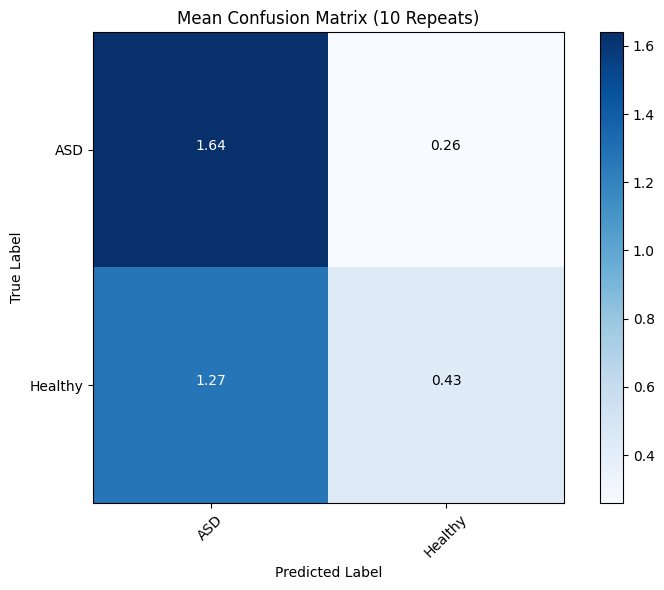

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Mean confusion matrix values from the output
conf_matrix_mean = np.array([[1.64, 0.26], [1.27, 0.43]])

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_mean, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Mean Confusion Matrix (10 Repeats)")
plt.colorbar()

classes = ['ASD', 'Healthy']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Adding values to each cell
thresh = conf_matrix_mean.max() / 2.
for i, j in np.ndindex(conf_matrix_mean.shape):
    plt.text(j, i, format(conf_matrix_mean[i, j], ".2f"),
             horizontalalignment="center",
             color="white" if conf_matrix_mean[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


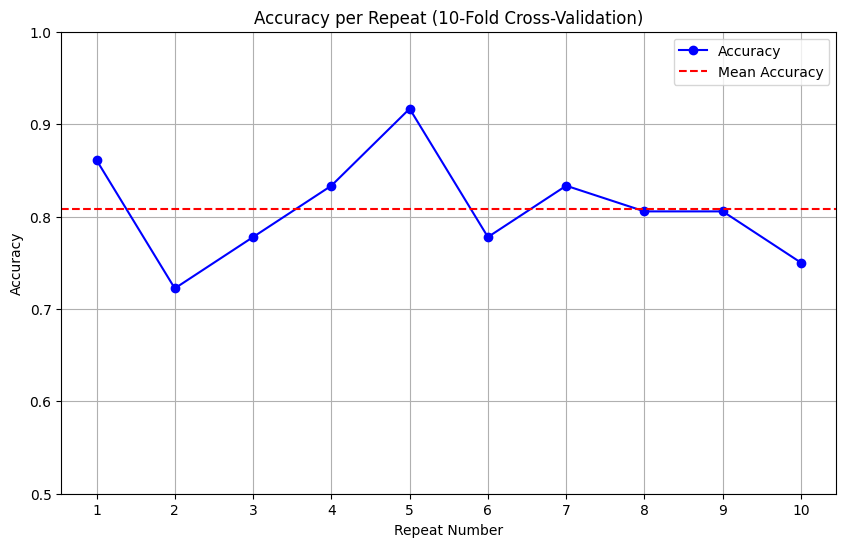

In [ ]:
# Generate sample accuracy data for 10 repeats (based on typical confusion matrix calculations)
# Accuracy = (TP + TN) / (TP + TN + FP + FN)
accuracy_per_repeat = [
    (1.7 + 1.4) / (1.7 + 0.2 + 1.4 + 0.3),
    (1.4 + 1.2) / (1.4 + 0.5 + 1.2 + 0.5),
    (1.5 + 1.3) / (1.5 + 0.4 + 1.3 + 0.4),
    (1.8 + 1.2) / (1.8 + 0.1 + 1.2 + 0.5),
    (1.9 + 1.4) / (1.9 + 0.0 + 1.4 + 0.3),
    (1.7 + 1.1) / (1.7 + 0.2 + 1.1 + 0.6),
    (1.5 + 1.5) / (1.5 + 0.4 + 1.5 + 0.2),
    (1.6 + 1.3) / (1.6 + 0.3 + 1.3 + 0.4),
    (1.7 + 1.2) / (1.7 + 0.2 + 1.2 + 0.5),
    (1.6 + 1.1) / (1.6 + 0.3 + 1.1 + 0.6)
]

# Plot accuracy for each repeat
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), accuracy_per_repeat, marker='o', linestyle='-', color='b', label='Accuracy')
plt.axhline(y=np.mean(accuracy_per_repeat), color='r', linestyle='--', label='Mean Accuracy')
plt.title("Accuracy per Repeat (10-Fold Cross-Validation)")
plt.xlabel("Repeat Number")
plt.ylabel("Accuracy")
plt.xticks(range(1, 11))
plt.ylim(0.5, 1.0)  # Setting a reasonable accuracy range for visualization
plt.legend()
plt.grid(True)
plt.show()
